In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.95 ms


### Load Annotated Data

In [3]:
d_b, d_r = load_cf_data()

time: 16 s


In [4]:
l_b = average(d_b['aggression_score'].dropna())
l_r = average(d_r['aggression_score'].dropna())

time: 65.9 ms


In [5]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 675 ms


### Split into train/dev and test

In [6]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 42.6 ms


In [7]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 8.25 ms


In [8]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 6.02 ms


In [9]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

19

time: 40 ms


### NGram Regression Pipeline

In [9]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge()),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.0001, 0.001, 0.01, 0.1, 1),
}

time: 321 ms


### Hyper-Parameter tuning

In [11]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)


Best parameters set found:
{'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 1} -0.191588476822


Grid scores:
-0.22711 (+/-0.00235) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.0001}
-0.22548 (+/-0.00231) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.001}
-0.21973 (+/-0.00215) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.01}
-0.20522 (+/-0.00180) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.1}
-0.19159 (+/-0.00134) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 1}
time: 27min 55s


In [10]:
## Be very careful to transcribe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge(alpha = 1.0)),
])

time: 1.9 ms


### Train on blocked

In [11]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 1min 27s


Eval on blocked

Explained Variance: 0.716
R^2: 0.716
RMSE: 0.440
Mean absolute error: 0.333
Median absolute error: 0.262
Pearson: 0.846
Spearman: 0.758


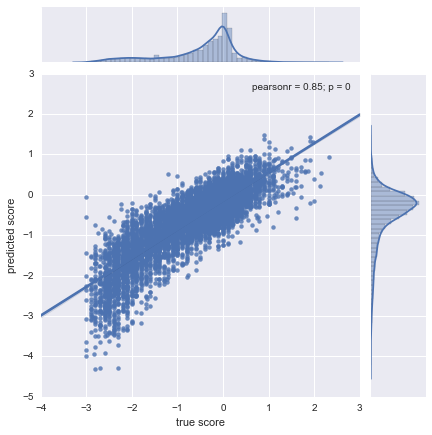

time: 19 s


In [13]:
print('Eval on blocked\n')
_= eval_regression(b_model, b_test, plot = True)

Eval on random

Explained Variance: 0.345
R^2: 0.140
RMSE: 0.355
Mean absolute error: 0.268
Median absolute error: 0.208
Pearson: 0.638
Spearman: 0.536


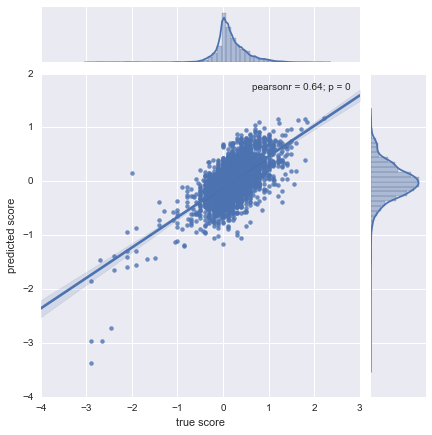

time: 8.12 s


In [14]:
print('Eval on random\n')
_= eval_regression(b_model, r_test, plot = True)

### Train on random

In [15]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 37.6 s


Eval on blocked

Explained Variance: 0.498
R^2: 0.296
RMSE: 0.692
Mean absolute error: 0.476
Median absolute error: 0.288
Pearson: 0.710
Spearman: 0.635


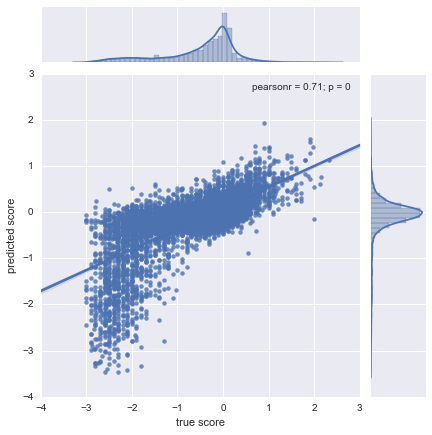

time: 19.8 s


In [16]:
print('Eval on blocked\n')
_= eval_regression(r_model, b_test, plot = True)

Eval on random

Explained Variance: 0.491
R^2: 0.491
RMSE: 0.273
Mean absolute error: 0.194
Median absolute error: 0.143
Pearson: 0.701
Spearman: 0.630


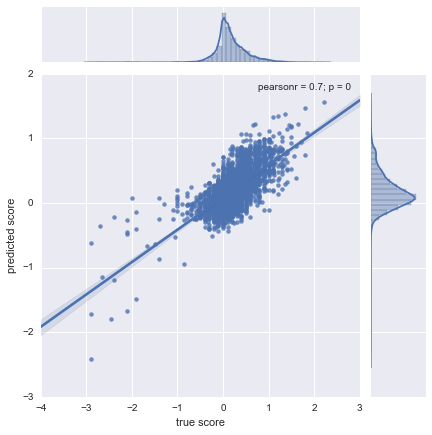

time: 7.85 s


In [17]:
print('Eval on random\n')
_= eval_regression(r_model, r_test, plot =  True)

### Train on both

In [18]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 2min 9s


Eval on blocked

Explained Variance: 0.719
R^2: 0.717
RMSE: 0.439
Mean absolute error: 0.328
Median absolute error: 0.252
Pearson: 0.848
Spearman: 0.768


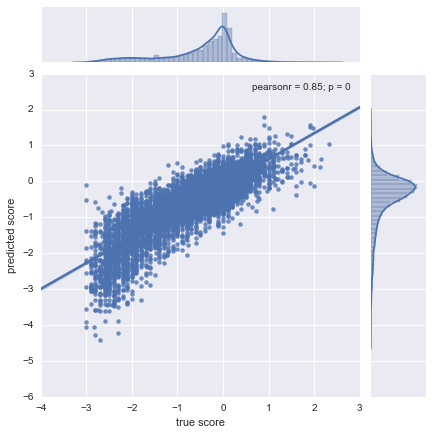

time: 20.1 s


In [19]:
print('Eval on blocked\n')
_= eval_regression(br_model, b_test, plot = True)

Eval on random

Explained Variance: 0.388
R^2: 0.327
RMSE: 0.314
Mean absolute error: 0.235
Median absolute error: 0.181
Pearson: 0.670
Spearman: 0.573


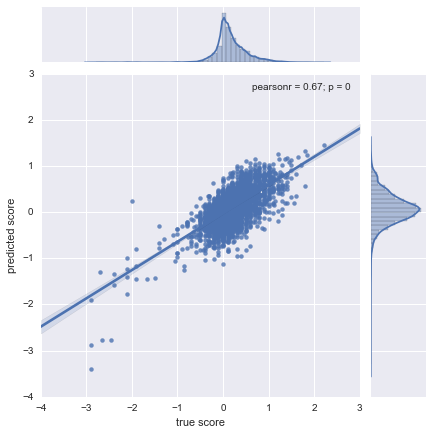

time: 7.85 s


In [20]:
print('Eval on random\n')
_= eval_regression(br_model, r_test, plot = True)

Eval on both

Explained Variance: 0.732
R^2: 0.732
RMSE: 0.408
Mean absolute error: 0.303
Median absolute error: 0.230
Pearson: 0.856
Spearman: 0.767


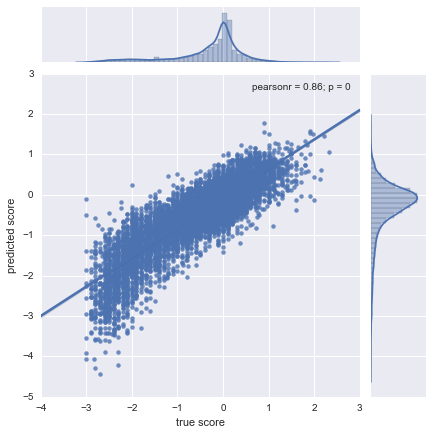

time: 26.5 s


In [21]:
print('Eval on both\n')
_= eval_regression(br_model, br_test, plot = True)

### Error Analysis

In [ ]:
d_redisdual = get_reg_residuals(br_model, br_test)
print_reg_errors(d_redisdual, n=10)

### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked data as we add more training data.

In [28]:
def get_r2(model, test):
    return r2_score(test['y'], model.predict(test['x']))

time: 4.02 ms


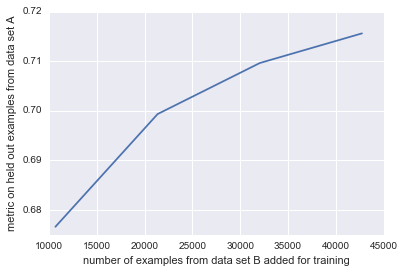

time: 6min 12s


In [29]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_r2)
plot_adding_other_data(ms, metrics)

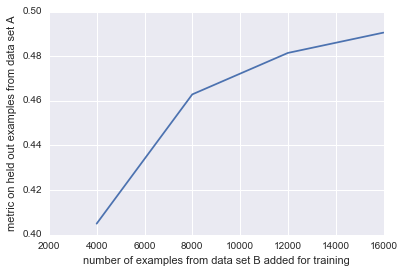

time: 2min 26s


In [30]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, r_test, r_train, get_r2)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

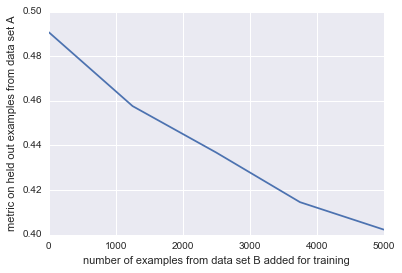

time: 3min 54s


In [32]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train[:5000], get_r2)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

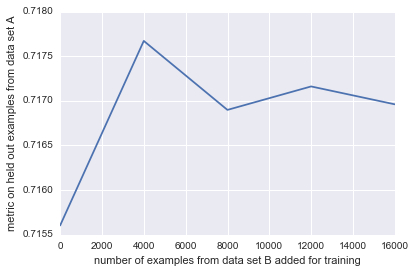

time: 10min 19s


In [33]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_r2)
plot_adding_other_data(ms, metrics)

# Final Model

In [40]:
br_data = pd.concat([data_r,data_b[:1500]])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/aggression_regression_ngram.pkl')

['../../models/aggression_regression_ngram.pkl',
 '../../models/aggression_regression_ngram.pkl_01.npy',
 '../../models/aggression_regression_ngram.pkl_02.npy',
 '../../models/aggression_regression_ngram.pkl_03.npy',
 '../../models/aggression_regression_ngram.pkl_04.npy']

time: 20.4 s
